In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.layers import *
from tensorflow import keras
from keras.utils.vis_utils import plot_model

Download the caltech_birds2010 dataset

In [ ]:
dataset, info = tfds.load('CaltechBirds2010:0.*.*', with_info=True)

# **D_LinkNet:**

# Preprocessing data


In [53]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000


image_size = 256

In [54]:
def normalize(input_image, input_mask):
  input_image = input_image/255.
  input_mask = input_mask / 255.
  return input_image, input_mask




**Data augmentation:**


In [55]:
@tf.function
def load_image_train(datapoint):
  #Resize
  
  input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_image = tf.image.flip_up_down(input_image)
    input_image = tf.image.adjust_brightness(input_image,0.5)
    input_image = tf.image.central_crop(input_image,0.5)
    input_image = tf.image.resize_with_crop_or_pad(input_image,image_size,image_size)

    input_mask = tf.image.flip_left_right(input_mask)
    input_mask = tf.image.flip_up_down(input_mask)
    input_mask = tf.image.adjust_brightness(input_mask,0.5)
    input_mask = tf.image.central_crop(input_mask,0.5)
    input_mask = tf.image.resize_with_crop_or_pad(input_mask,image_size,image_size)


  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [56]:
def load_image_test(datapoint):
  #Resize
  
  input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [57]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [58]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i>0:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='gray')
    else:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

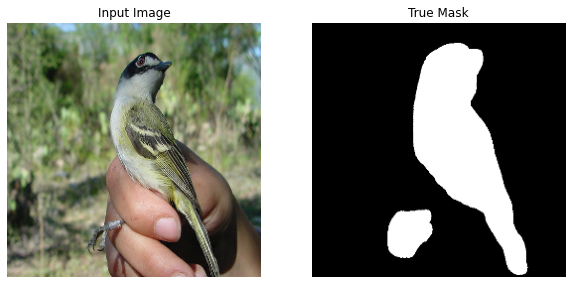

In [59]:
for image, mask in train.take(6):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# D_linknet architecture:

https://sci-hub.se/10.1109/CVPRW.2018.00034



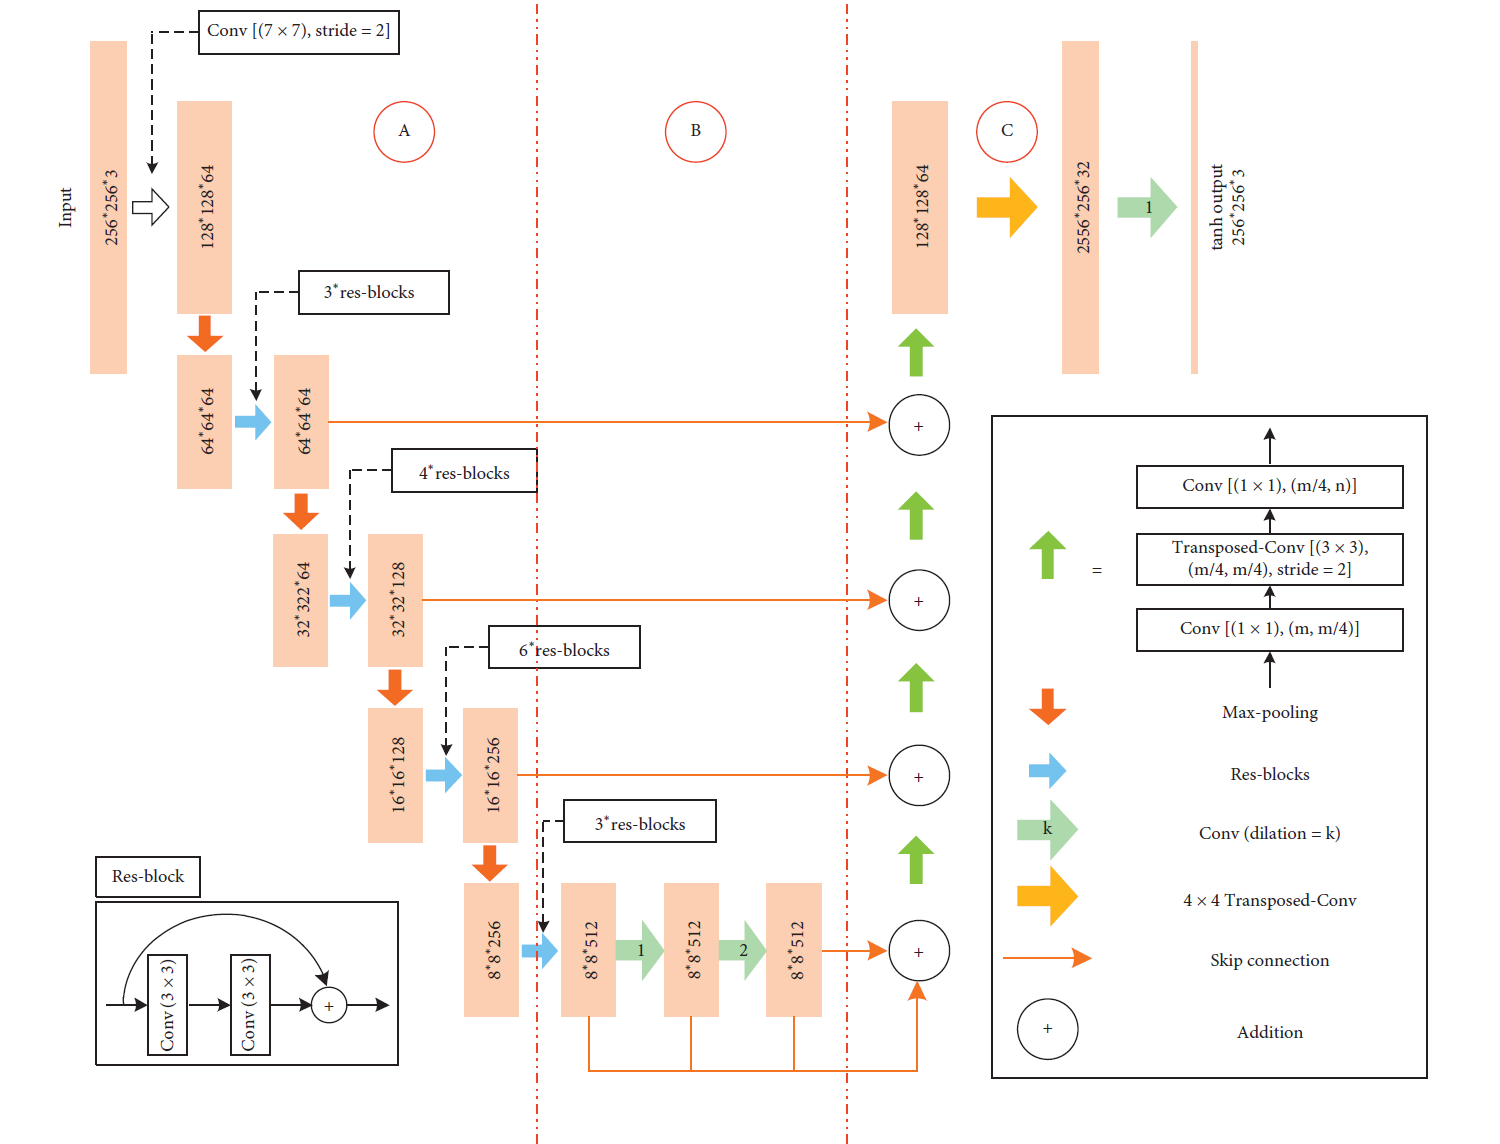


You can use the following link to get acquainted with convolution2d_transpose


https://keras.io/api/layers/convolution_layers/convolution2d_transpose/


In [ ]:

# define a D_linknet
res50 = keras.applications.ResNet50(include_top=False,input_shape=(image_size,image_size,3))
from keras.utils.vis_utils import plot_model
plot_model(res50,show_shapes=True,dpi=60)

In [ ]:
for layer in res50.layers:
  layer.trainable = False
e1 = res50.get_layer('conv2_block3_out').output
e1 = Conv2D(64,1,padding='same',activation='relu')(e1)

e2 = res50.get_layer('conv3_block4_out').output
e2 = Conv2D(128,1,padding='same',activation='relu')(e2)

e3 = res50.get_layer('conv4_block6_out').output
e3 = Conv2D(256,1,padding='same',activation='relu')(e3)

e4 = res50.get_layer('conv5_block3_out').output
e4 = Conv2D(512,1,padding='same',activation='relu')(e4)

b1 = Conv2D(512,3,dilation_rate=(1,1),padding='same',activation='relu')(e4)
b2 = Conv2D(512,3,dilation_rate=(2,2),padding='same',activation='relu')(b1)

d4 = Add()([e4,b1,b2])
d4 = Conv2D(64,1,padding='same',activation='relu')(d4)
d4 = Conv2DTranspose(64,3,2,padding='same',activation='relu')(d4)
d4 = Conv2D(256,1,padding='same',activation='relu')(d4)

d3 = Add()([d4,e3])
d3 = Conv2D(32,1,padding='same',activation='relu')(d3)
d3 = Conv2DTranspose(32,3,2,padding='same',activation='relu')(d3)
d3 = Conv2D(128,1,padding='same',activation='relu')(d3)

d2 = Add()([d3,e2])
d2 = Conv2D(16,1,padding='same',activation='relu')(d2)
d2 = Conv2DTranspose(16,3,2,padding='same',activation='relu')(d2)
d2 = Conv2D(64,1,padding='same',activation='relu')(d2)

d1 = Add()([d2,e1])
d1 = Conv2D(16,1,padding='same',activation='relu')(d1)
d1 = Conv2DTranspose(16,3,2,padding='same',activation='relu')(d1)
d1 = Conv2D(64,1,padding='same',activation='relu')(d1)

outputs = Conv2DTranspose(32,4,2,padding='same',activation='relu')(d1)
outputs = Conv2D(3,1,padding='same',activation='tanh')(outputs)

Dlinknet = keras.models.Model(res50.layers[0].input,outputs)
Dlinknet.summary()

# Compile the model
Use Adam optimizer with learning rate 0.001 and BinaryCrossentropy with from_logits=True

Set accuracy for metrics

In [73]:
#Compile
optimizer = keras.optimizers.Adam(0.001)
loss = keras.losses.BinaryCrossentropy(from_logits=False)
Dlinknet.compile(optimizer='adam',loss=loss,metrics=['accuracy'])

# Fit the model

In [ ]:
EPOCHS = 30
VAL_SUBSPLITS = 5 
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

#Complete with train_data, epochs, steps_per_epoch, validation_steps, validation_data
history = Dlinknet.fit(train_dataset,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS,validation_data=test_dataset)
# ****** The bellow code is executed for sigmoid function but the main code and main model use tanh activation function.**************

# Predict


In [64]:
def show_predictions(dataset, num=10):
  for image, mask in dataset.take(num):
      #Prediction
      pred_mask = Dlinknet.predict(image) 
      display([image[0], mask[0], pred_mask[0]])

In [ ]:
show_predictions(test_dataset)